# HarvestStat Data Profiling - Rwanda

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32735' # Rwanda
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/RW_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country':  'Rwanda',
    'product': ['R011','R012','R013','R014','R015','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint,  params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1959	 | RW1959A1 | 10	| nan	| 0	| nan	| 0	|
| 1992	 | RW1992A1 | 11	| nan	| 0	| nan	| 0	|
| 1996	 | RW1996A1 | 12	| nan	| 0	| nan	| 0	|
| 2006	 | RW2006A1 | 5	| RW2006A2	| 30	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_RW.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_RW.csv is saved.


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
df = df[np.isfinite(df.value)]
df_admin1=df[df['admin_2'].isna()]
df = df.dropna(subset=['admin_2'])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority="Area Planted")
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([RW_Admin2_2006], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 8,409
Removed 11 "Missing Value" points
2,205/2,205 "Area Planted" points are retained.
4,032/4,038 "Quantity Produced" points are retained.
2,161/2,166 "Yield" points are retained.
Current data points: 8,398

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 2008 - 2017
38 grain types are found: Avocado (Hass), Avocado (unspecified), Banana (unspecified), Beans (mixed), Beet, Bush bean, Cabbage (Unspecified), Carrots, Cassava, Cassava (non-bitter), Cauliflowers, Celery, Cereal Crops (Mixed), Champignon, Cooking Banana (unspecified), Eggplant, Green bean (fresh), Green pea, Groundnuts (In Shell), Leeks, Maize Grain (Fresh), Maize Grain (White), Okras (Fresh), Pea (unspecified), Pole bean, Potato (Irish), Rice (Paddy), Sorghum, Soybean (unspecified), Spinach, Squash (Unspecified), Sugarcane (for sugar), Sunflower Seed, Sweet Potatoes, Taro/Cocoyam (Unsp

- Rwanda crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-rwanda.png?itok=6LEEa9FZ" width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/eafrica_rw_calendar.png" width=900>

- comparison of boundaries</br>

<img src="../figures/RW_admin_shapes.png" width=900>

- In Rwanda, basd on the FEWS NET data, there were three times of changes in administrative units. We will use the 2006 administrative units

| Year  | Admin-1  | # units  | Admin-2  | # units | Admin-3  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   | :----:   | :---:   |
| 1959	 | RW1959A1 | 10	| nan	| 0	| nan	| 0	|
| 1992	 | RW1992A1 | 11	| nan	| 0	| nan	| 0	|
| 1996	 | RW1996A1 | 12	| nan	| 0	| nan	| 0	|
| 2006	 | RW2006A1 | 5	| RW2006A2	| 30	| nan	| 0	|

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = RW_Admin2_2006.copy().to_crs('epsg:32735')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area_new, prod_new = FDW_PD_Compiling(df, shape_used)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Remove certain crops -------------------------- #
# Remove some crops only 2008 data and similar crop type exists (Donghoon)
product_remove = ['Avocado (Hass)', 'Cassava (non-bitter)', 'Maize Grain (Fresh)']
stack = stack[~stack['product'].isin(product_remove)]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_RW.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_RW.csv is saved.


# Visualization of production data

/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


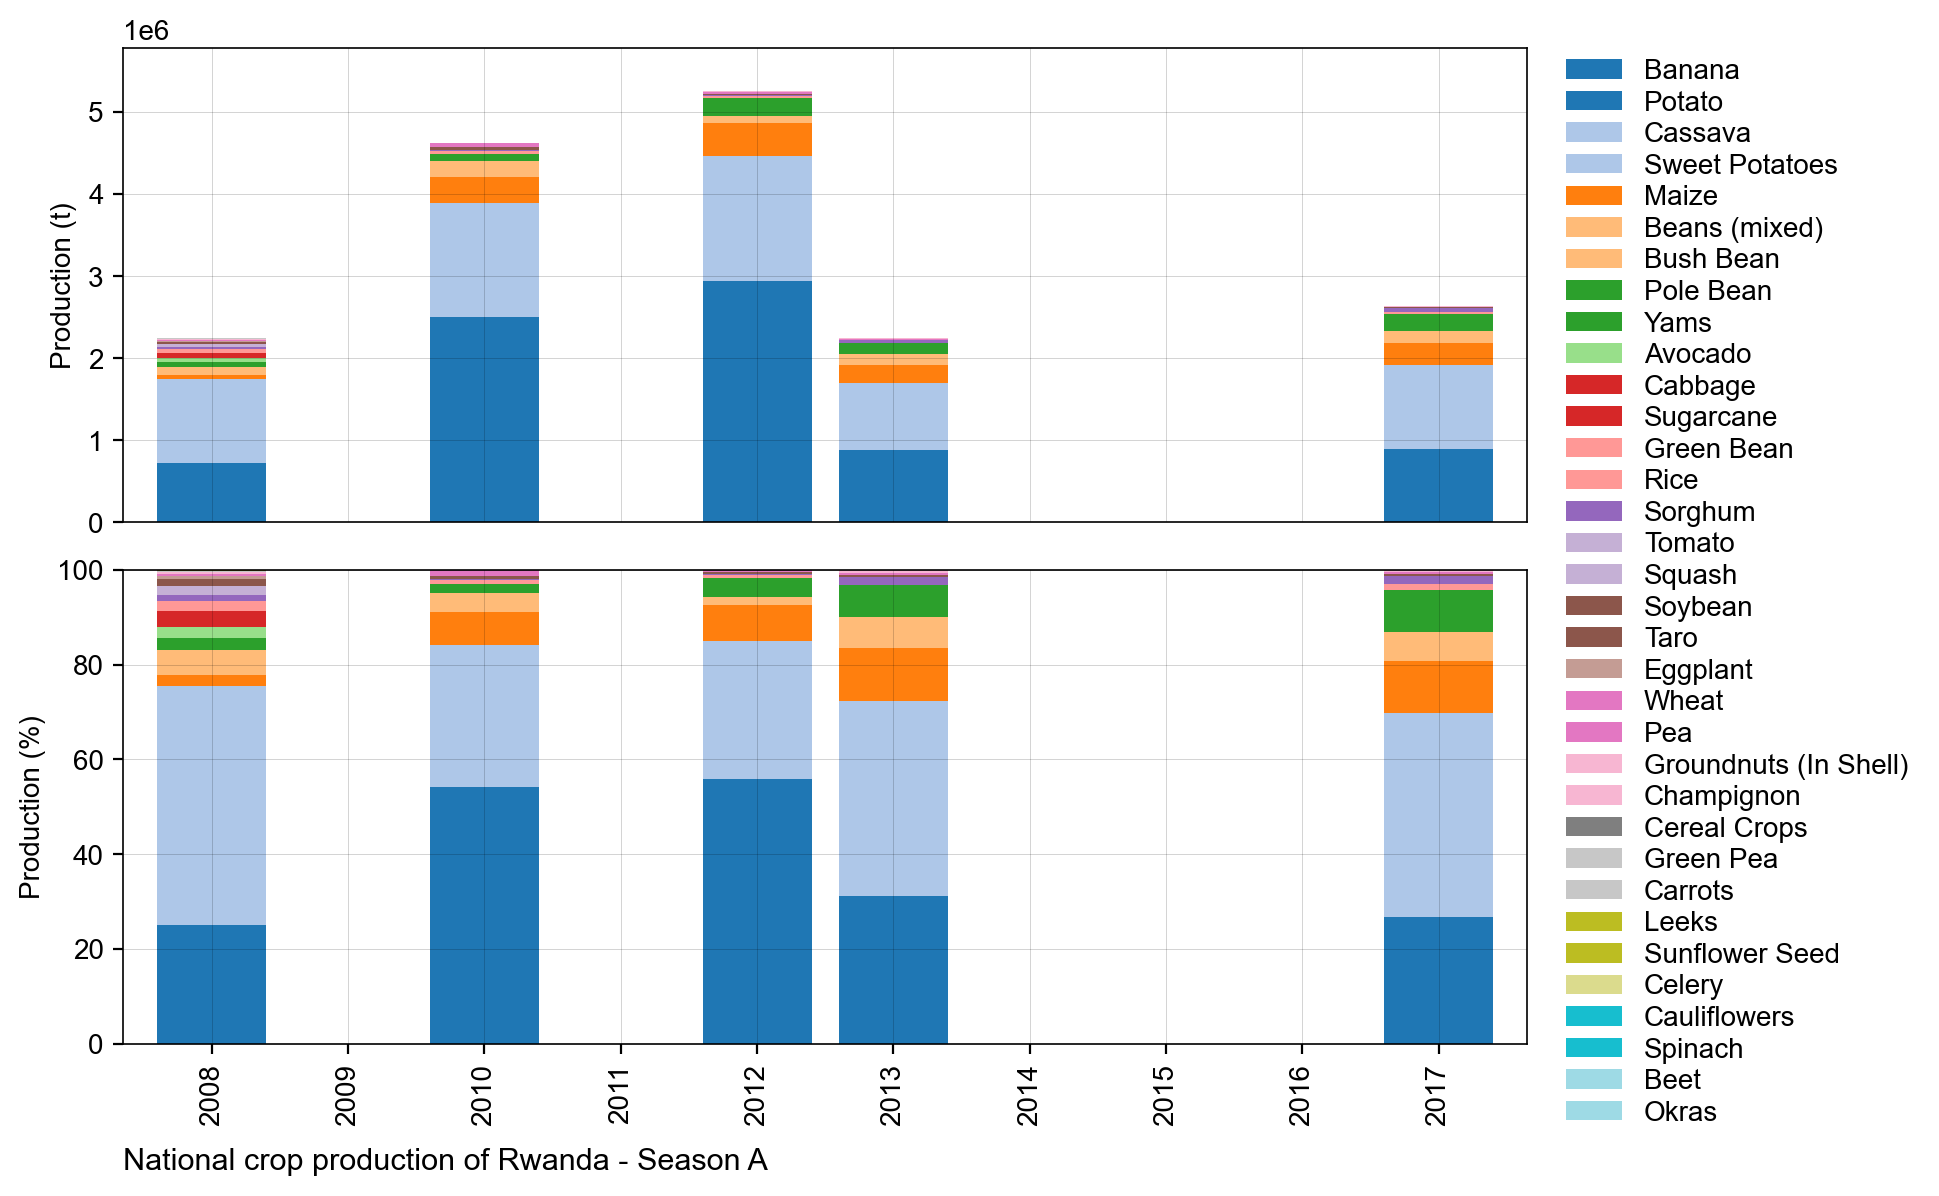

../figures/RW_bar_natgrainprod_Season A.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


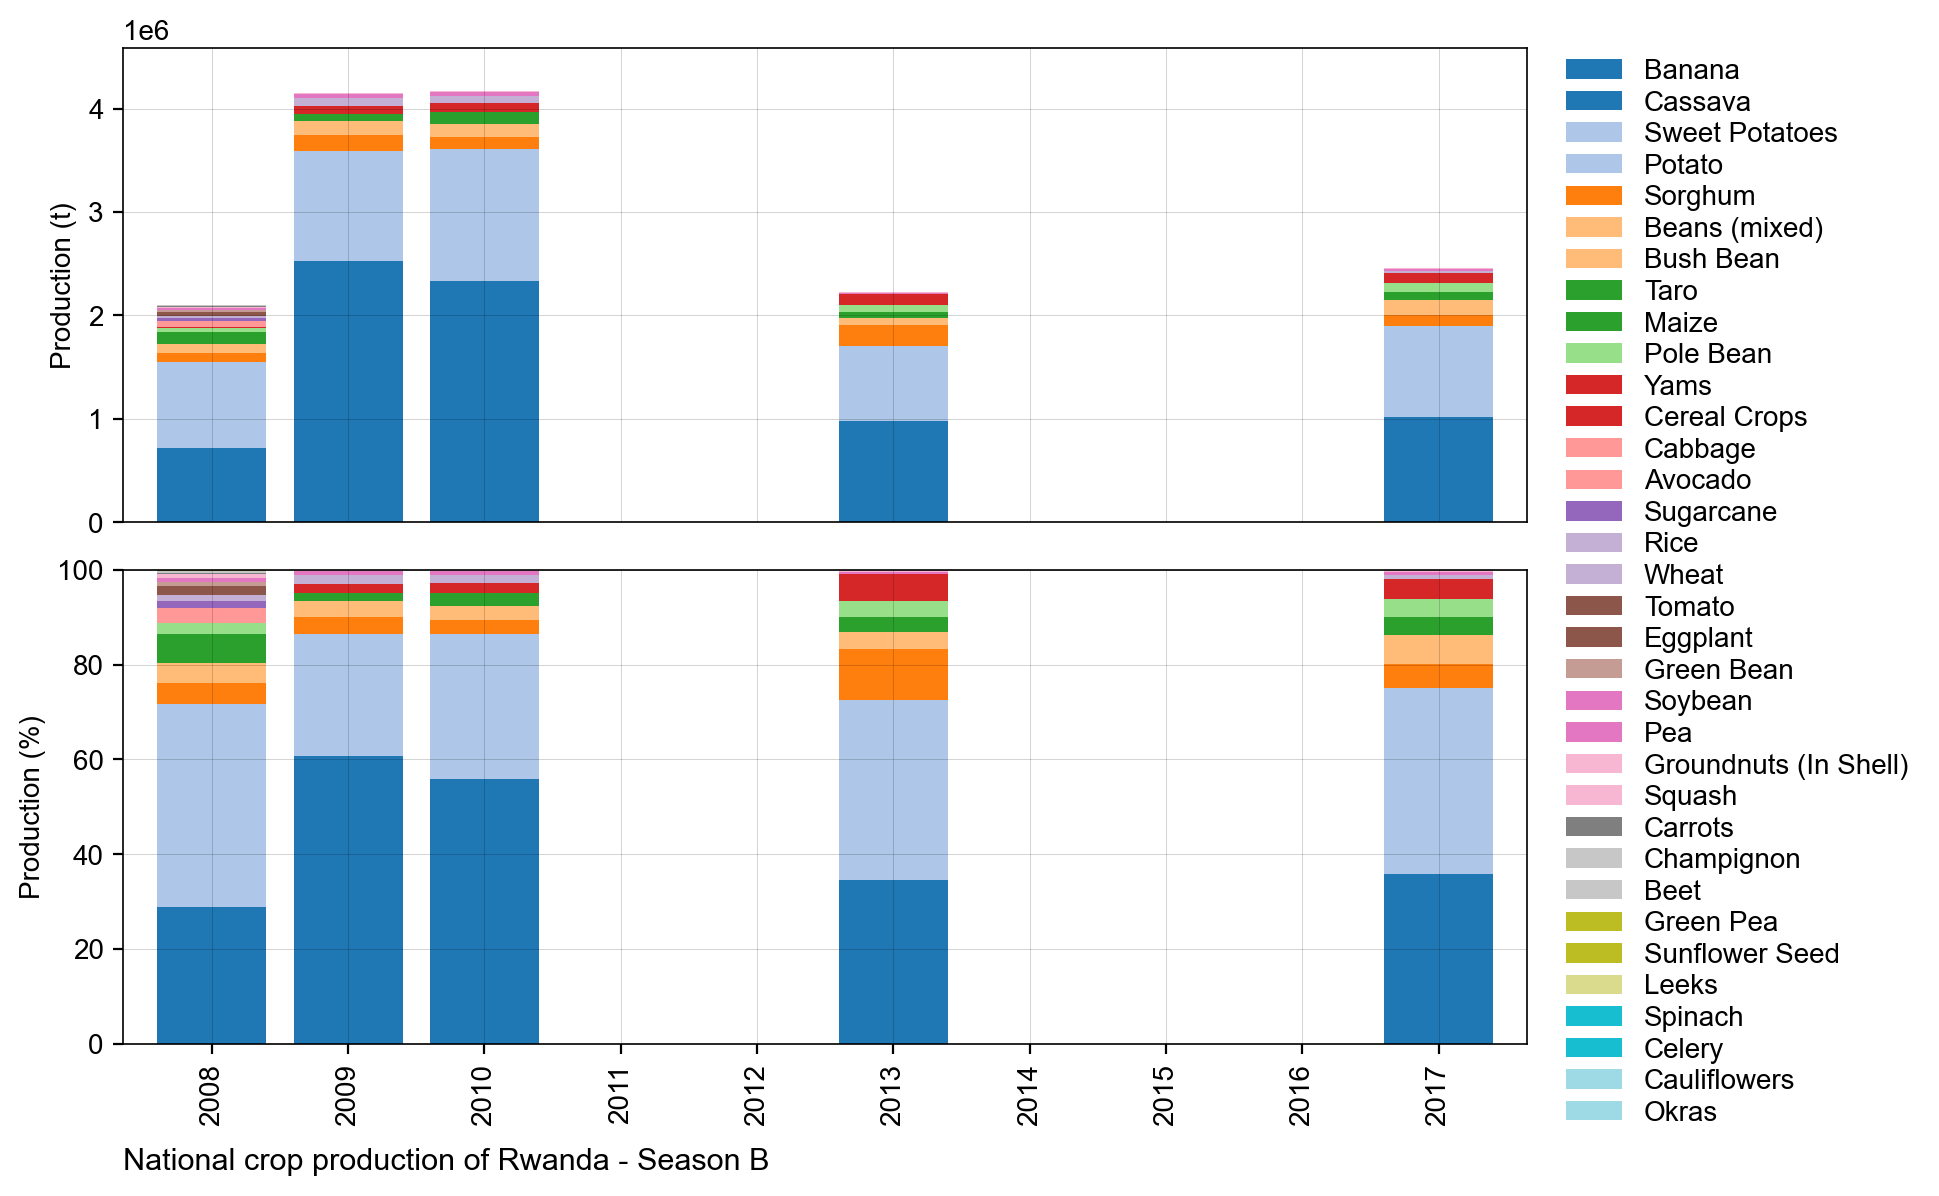

../figures/RW_bar_natgrainprod_Season B.png is saved.


/Users/weston/Documents/Code/Project/HarvestStat/HarvestStat/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


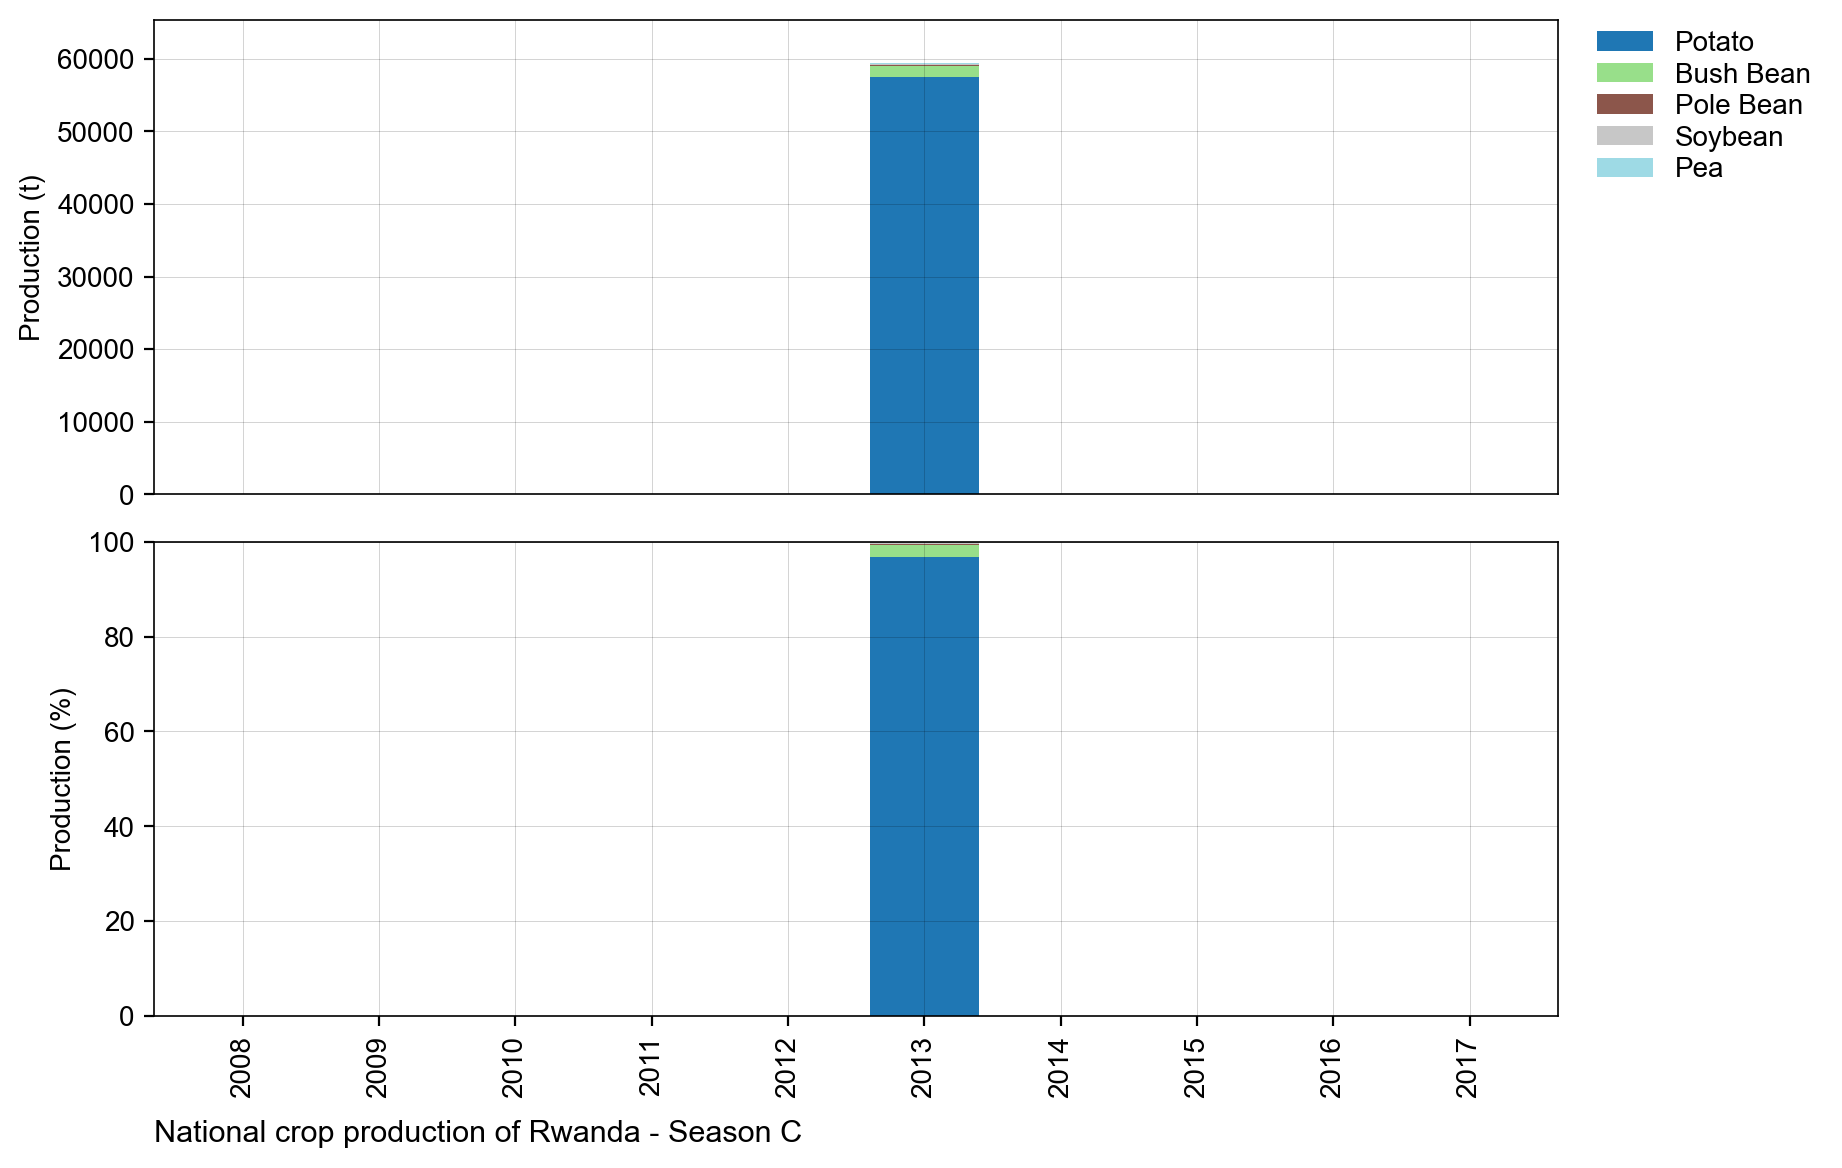

../figures/RW_bar_natgrainprod_Season C.png is saved.


In [7]:
# Bar chart of national crop production
country_iso, country_name = 'RW', 'Rwanda'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name   in ['Season A','Season B','Season C']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

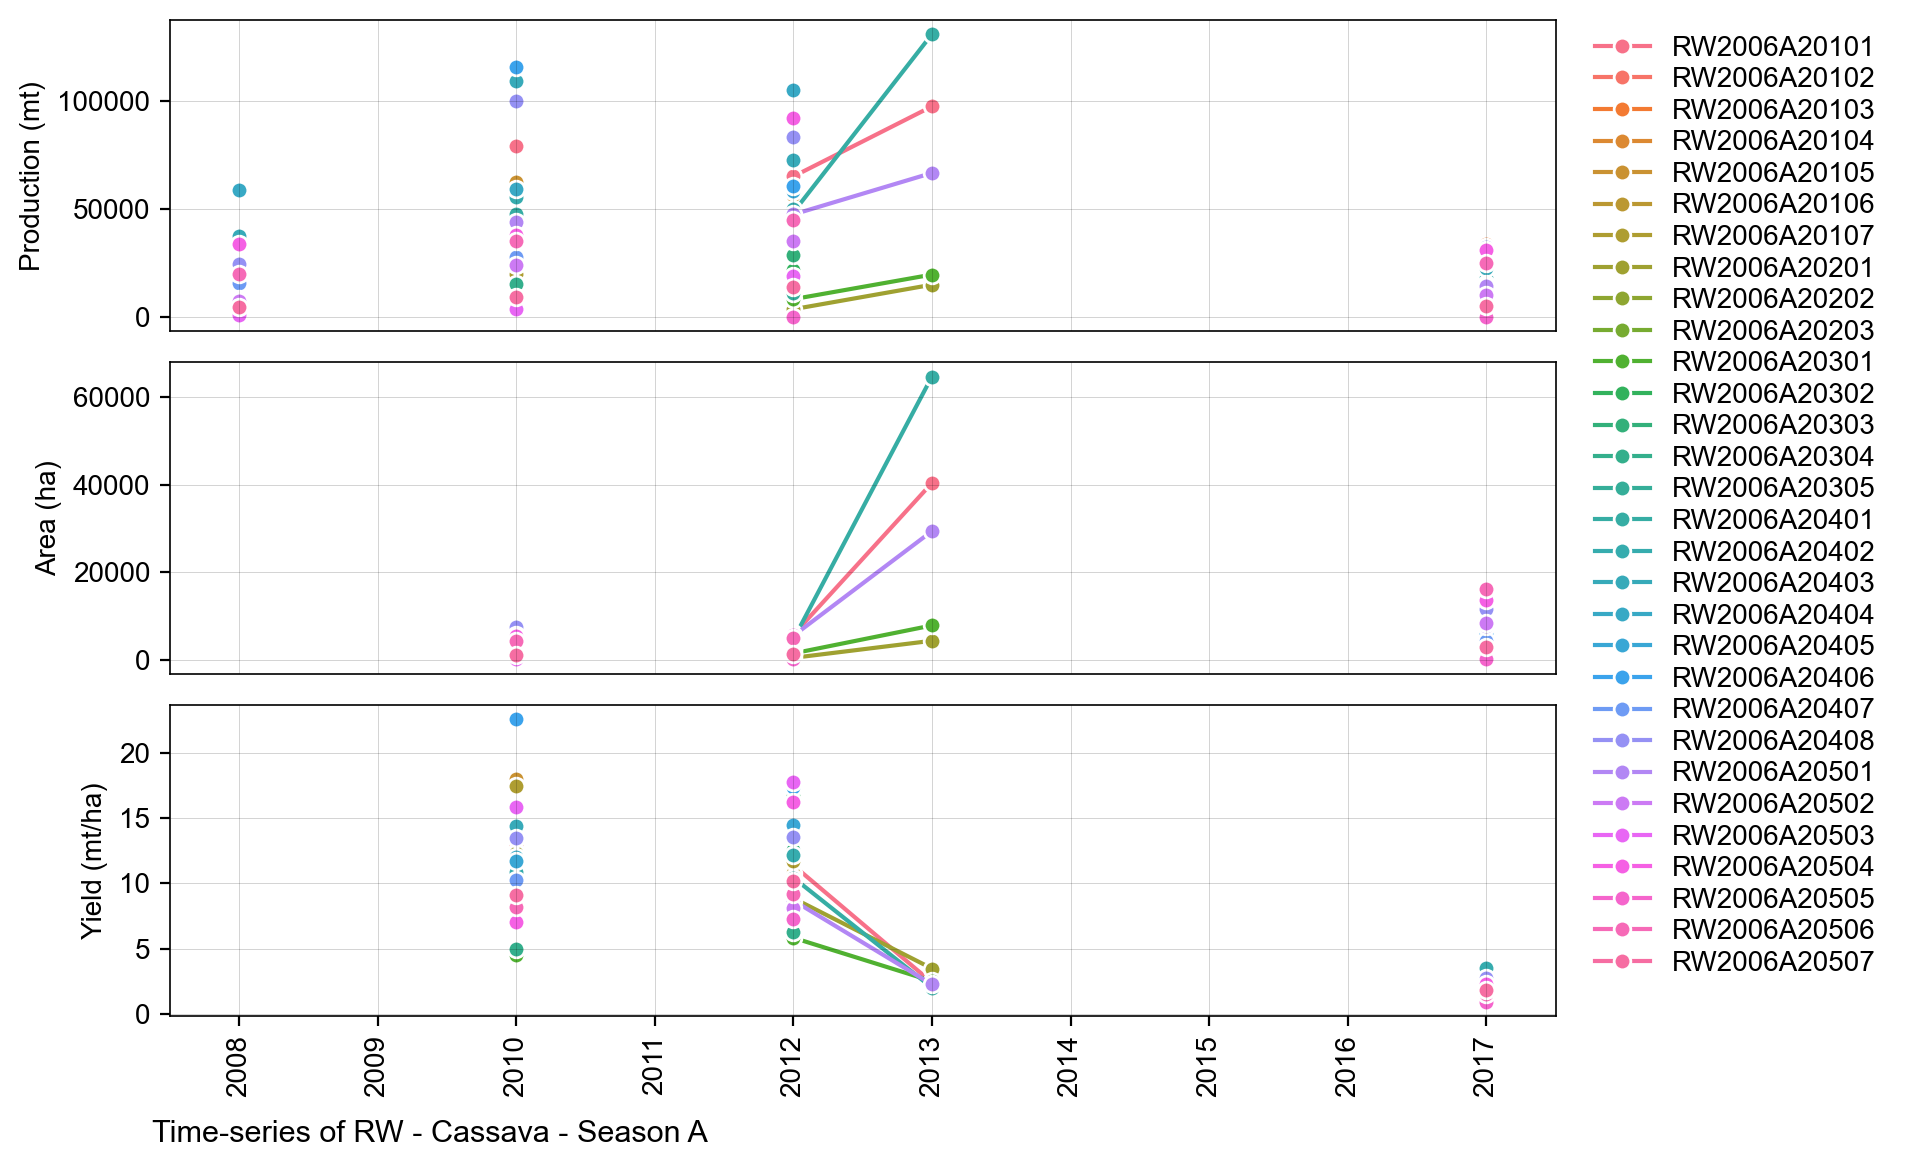

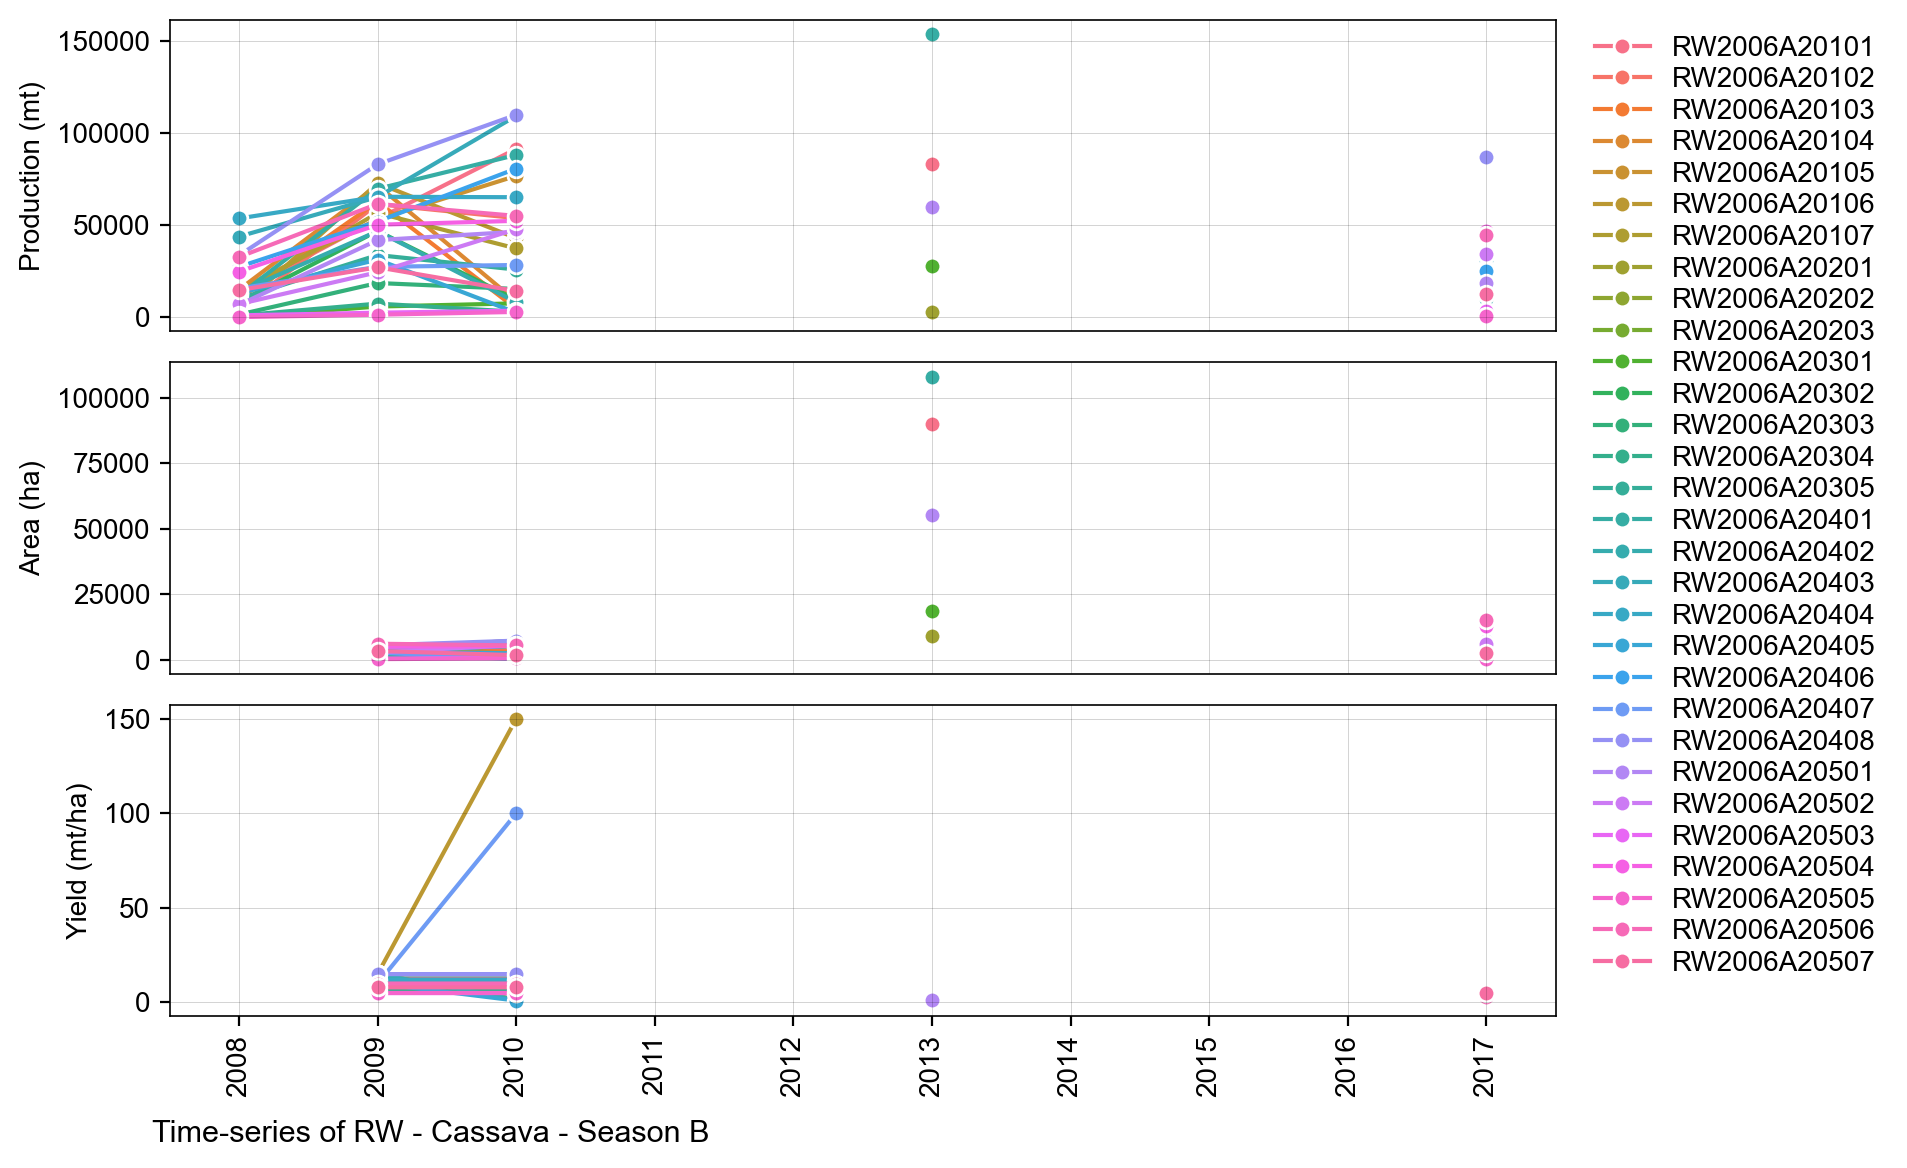

In [8]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'RW', 'Rwanda'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
     ['Cassava','Season A'],
     ['Cassava','Season B'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)